In [22]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, os.path.abspath('../src'))
from shallowwater import (ModelParams, make_grid, setup_initial_state,
                          zero_forcing, run_model, compute_dt_cfl,
                          geostrophic_velocities_from_eta)
import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# --- Geostrophic adjustment from a Gaussian bump (f-plane, modest friction) ---

# Basin & grid (a bit larger so gravity waves have room before reflecting)
Nx, Ny = 160, 160
Lx, Ly = 4.0e6, 4.0e6
grid = make_grid(Nx, Ny, Lx, Ly)

# f-plane, modest friction (as you had)
params = ModelParams(
    H=1000.0, g=9.81, rho=1025.0,
    f0=1.0e-4, beta=0.0, y0=Ly/2,
    r=1/(3*86400),   # ~3-day Rayleigh
    linear=True
)

def ic_balanced_fraction(g, p,
                         amp=0.5, R=2.0e5, x0=None, y0=None,
                         degree_of_balance=1.0,  # 1.0 = fully geostrophic, 0.5 = half, etc.
                         alpha=0.95,             # slight under-balance to reduce IG noise
                         sponge=6):
    eta0, _, _ = setup_initial_state(
        g, p, mode="gaussian_bump",
        amp=amp, R=R,
        x0=(g.Lx/2 if x0 is None else x0),
        y0=(g.Ly/2 if y0 is None else y0),
    )
    u0, v0 = geostrophic_velocities_from_eta(
        eta0, g, p,
        degree_of_balance=degree_of_balance,
        alpha=alpha,
        sponge=sponge
    )
    return eta0, u0, v0

# Pick how geostrophic you want to start:
#   1.0  → nearly balanced (very little IG ringing)
#   0.7  → partly balanced (some IG waves, faster adjustment)
#   0.0  → unbalanced (pure bump; classic adjustment burst)
ic_fn = lambda g, p: ic_balanced_fraction(g, p, degree_of_balance=0.8)

forcing_fn = lambda t, g, p: zero_forcing(t, g, p)

out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=20, out_vars=("eta","u","v"))

print("Saved steps:", len(out["time"]))


Saved steps: 103


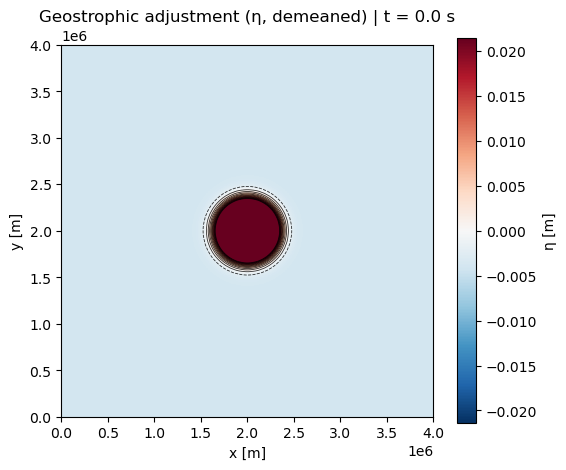

In [24]:
from shallowwater.visualize import animate_eta

anim = animate_eta(out, grid, interval=100, contours=True, contour_levels=21,
                   title="Geostrophic adjustment (η, demeaned)")

# GIF (no external dependencies)
anim.save("eta_10.gif", fps=10)

Corr(U, u_g) = 0.916,   Corr(V, v_g) = 0.916


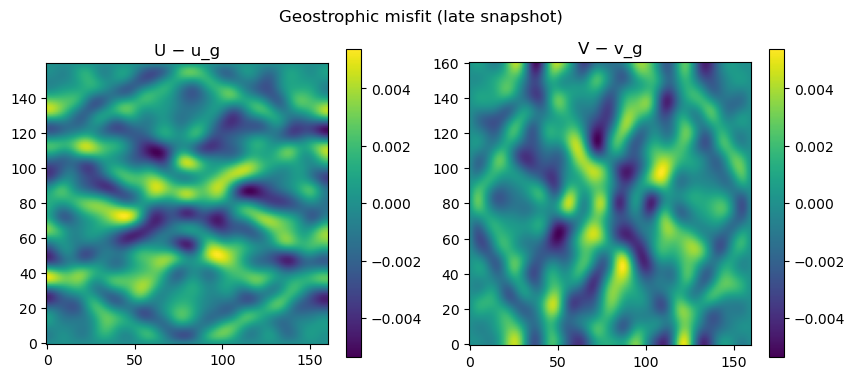

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Late snapshot
ETA = np.array(out["eta"])[-1]   # (Ny, Nx)
U   = np.array(out["u"])[-1]     # (Ny, Nx+1)
V   = np.array(out["v"])[-1]     # (Ny+1, Nx)

u_g, v_g = geostrophic_velocities_from_eta(
        ETA, grid, params
    )

# If you prefer simpler: just correlate full arrays (same shapes) without cropping:
corr_u = np.corrcoef(U.ravel(), u_g.ravel())[0,1]
corr_v = np.corrcoef(V.ravel(), v_g.ravel())[0,1]
print(f"Corr(U, u_g) = {corr_u:.3f},   Corr(V, v_g) = {corr_v:.3f}")

# Misfit maps (use matching shapes!)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(U - u_g, origin="lower"); plt.title("U − u_g"); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(V - v_g, origin="lower"); plt.title("V − v_g"); plt.colorbar()
plt.suptitle("Geostrophic misfit (late snapshot)")
plt.show()
